<a href="https://colab.research.google.com/github/balajisriraj/Twitter-Summary-mini-Project/blob/main/Twitter_Trend_Finder_In_Progress_V0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Flow:

- Connect to Twittter API using the required creds
- Find the Top trending Hashtags
- Then filter the hashtags which are in English language
- Filter Top 3 Hashtags from that
- For these 3 hashtags, fetch 100 Tweets individually
- Combain all the 100 tweets into one big corpus
- Do basic Data Cleaning & Processing for better Tokenization
- Using Text to Text transformer t5 model Summarize the tweets
- Show Summarized text output for each Hashtag

In [18]:
#Installing the required packages 
!pip install googletrans 
! pip install transformers
#! pip install preprocessor

Import Python Modules

In [19]:
import pandas as pd
import tweepy
from tweepy import OAuthHandler
from tweepy import API
from googletrans import Translator
import datetime
import copy
import string
import re
import preprocessor as p
import matplotlib as mpl
import matplotlib.pyplot as plt
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config, AutoModelWithLMHead, AutoTokenizer
import os
import textwrap

In [20]:
#Basic Settings
#p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY,p.OPT.MENTION)
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device('cuda')


#MODEL 2
#model = AutoModelWithLMHead.from_pretrained('distilgpt2')    # Download model and configuration from S3 and cache.
#tokenizer = AutoTokenizer.from_pretrained('distilgpt2')   # Initialize tokenizer
#tokenizer = AutoTokenizer.from_pretrained('gpt2')    

In [21]:
#Past the keys extracted from teh Twitter App


In [22]:
# Consumer key authentication(consumer_key,consumer_secret can be collected from our twitter developer profile)
auth = OAuthHandler(consumer_key, consumer_secret)
# Access key authentication(access_token,access_token_secret can be collected from our twitter developer profile)
auth.set_access_token(access_token, access_token_secret)
# Set up the API with the authentication handler
api = API(auth)

In [23]:
WOE_ID = 23424848 # Where on Earth id can be extracted from https://nations24.com/world-wide
lan_find = Translator() # for finding the language of the hashtags

In [24]:

def get_location_trends(locations, auth,n_hashtags,lang = 'en'):
  '''
  This function extracts the top trends for the selected location
  
  Function parameters 
  
  locations :   ID for the lcoation, which can be extarcted from https://nations24.com/world-wide
  auth      :   Authentication for Twitter API
  n_hashtags:   Integer Value, that defines number of top trending hashtags we are looking at
  lang      :   Language we are looking at for the tweets, by default its english
  '''
  api = API(auth)
  trends = api.trends_place(locations)
  data = trends[0]
  trends_data = data['trends']
  global tred_data
  tred_data = []
  for info in trends_data:
    tred_data.append([info['name'],info['tweet_volume'],lan_find.detect(info['name']).lang ] )
  tred_data = pd.DataFrame(tred_data, columns = list(['Hashtag',
                                                    'Tweet_Volume', 'Language'])).sort_values(by = ['Tweet_Volume'],ascending = False)
  #select english language trends
  tred_data = tred_data[tred_data.Language == lang]
  #select top 3 trends
  tred_data = tred_data.nlargest(n_hashtags,columns=['Tweet_Volume'])
  return tred_data

In [25]:
df_trending = get_location_trends(WOE_ID,auth,3,'en')
df_trending # Shows Top three hashtags & its corresponding Volume of Tweets

,Hashtag,Tweet_Volume,Language
16,#302ForSSRKillers,448180.0,en
8,We Stan Asim Forever,222448.0,en
15,#1YearOfBBAsuran,163334.0,en


In [26]:
hashtag_list = list(df_trending['Hashtag']) #Gets list of Top n hashtags
#hashtag_list = list(['#philosophy']) #Uncomment this & input any hashtag if you would like to look at any particulr hashtag 

In [27]:
def extract_tweets_for_htags(no_of_tweets,hashtag_list):
  '''
  This function extracts teh tweets for the Hashtags
  Parameters:
  no_of_tweets  : Integer, number of tweets to extract keep it between 100 to 500 for faster execution
  hashtag_list  : List of top trending Hashtags
  '''
  dict_of_df = {} 
  for htag in hashtag_list:
    today = datetime.datetime.now().strftime("%Y-%m-%d")
    tweets = tweepy.Cursor(api.search,q=htag,lang="en",since=today,wait_on_rate_limit = True,wait_on_rate_limit_notify = True ).items(no_of_tweets) #Extracting tweets for the htag
    tweets= [tweet.text for tweet in tweets] # Saving the tweets as list
    
    
    key_name = 'df_htag_'+str(htag)
    dict_of_df[key_name] = copy.deepcopy(tweets)
  return dict_of_df

In [28]:
dict_of_df = extract_tweets_for_htags(500,hashtag_list) #Dictionary that has data for all top three hashtags
hashtag_df_list = dict_of_df.keys() #List contains individual the key names for accessing the data inside the dictionary

In [29]:
def remove_punct(text):
    '''
    Remove punctuation of the string, and returns the string

    Parameters:
    text = String Value
  
    ''' 
  
    clean_text = []
    for tweet in text:
      tweet = re.sub(r"http\S+", "", tweet)
      text  = "".join([char for char in tweet if char not in string.punctuation])
      text = ''.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",text))
      text = text.replace('RT','').strip()
      clean_text.append(text)
    return clean_text


def wrap(line):
    broken = textwrap.wrap(line, 50, break_long_words=False)
    return '\n'.join(broken)

In [30]:
def clean_tweet():
  '''
  Function that returns cleaned string
  '''
  processed_data_dict = {}
  for htag in hashtag_df_list:
    df = dict_of_df[htag]
    df = remove_punct(df)
    key_name = str(htag)
    processed_data_dict[key_name] = copy.deepcopy(df)
  
  return processed_data_dict 

In [31]:
clean_data = clean_tweet()
df_clean_data = pd.DataFrame.from_dict(clean_data) # Dataframe taht contains string data for each hasgtag represented in each column
htags = df_clean_data.columns # Dataframe's Column list to iterate through data for each hashtag

In [32]:
def show_me_summary(htags,df):
  for htag in htags:
    temp =  df[htag].str.cat(sep=', ') # Select a column insert i here
    
    #Word Cloud
    htag = htag.split('_')[2]
    print(f'Word Cloud for the trending hashtag: {htag} \n') 
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color='white',stopwords=stopwords,max_words=200,max_font_size=40, random_state=42).generate(str(temp))
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show() # Shows teh Word Cloud for the Hashtag
    
    #Text Summary Model
    preprocess_text = temp.strip().replace("\n","") # Preprocessing the data
    #t5_prepared_Text = "summarize: "+preprocess_text
    t5_prepared_Text =preprocess_text
    # print ("Original text preprocessed: \n", preprocess_text) # Uncomment this to see the Original Text
    
    #MODEL 1
    tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt",  
                                      truncation=True,
                                      #padding=True, 
                                      add_special_tokens= True)
    # Converting teh Tokens into ids for the Model
    summary_ids = model.generate(tokenized_text,
                                 do_sample=False,
                                 min_length=50 ,
                                 max_length=160, 
                                 top_k=90, 
                                 top_p=0.90,
                                 num_return_sequences=1,
                                 num_beams=10,
                                 no_repeat_ngram_size=2,
                                 temperature=0.8,
                                 
                                 #early_stopping=True
       )
    
    
    output = tokenizer.decode(summary_ids[0], skip_special_tokens=True) # Decoding the Encoded ids into Words
    output = ('\n'.join(textwrap.wrap(output, 90, break_long_words=False)))
    
    
    print(f"\n\nSummarized text for {htag}: \n\n",output)
    print('*' *100)
    print('\n')

Word Cloud for the trending hashtag: #302ForSSRKillers 



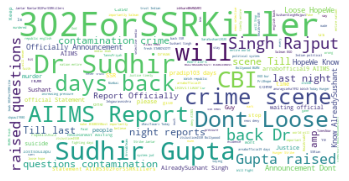



Summarized text for #302ForSSRKillers: 

 SSR broke his leg before hanging himself in a manner which is impossible according to
science amp mathDisha jumpedno fli, ShilpiFlyhigh Times to Unfollow few
accounts302ForSSRKillers, anuragsinha1992 Watch republic english The AIIMS news is
officially declaring it It isnt very difficult for them, pradip103 42 days back Dr Sudhir
Gupta raised questions on contamination of the crime scene Till last night there were
reports
****************************************************************************************************


Word Cloud for the trending hashtag: We Stan Asim Forever 



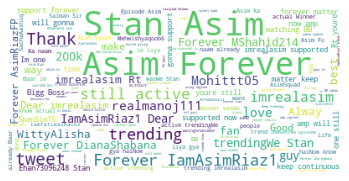



Summarized text for We Stan Asim Forever: 

 , AsimRiazFP Time for a Speed Booster this tweet amp drop at least 50 replies using the
tagline lets aim for 200 amp 200 rep, sajid007 ideboshree Arhaanalii PaltibaazaAwww tu
bhithnx, isanam Mehwishyaqoob6 iamamazyngg imrealasim Love youImforever, Gauhar is the
****************************************************************************************************


Word Cloud for the trending hashtag: #1YearOfBBAsuran 



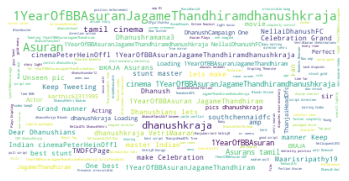



Summarized text for #1YearOfBBAsuran: 

 Mania Dhanush is the perfect Actor for any age character 1YearOfBBAsuranJagameThandhiram,
Maarisripathy19 Action sequences are amazing Asuran is a story of blood and flesh.
****************************************************************************************************




In [33]:
show_me_summary(htags=htags, df =df_clean_data )